## Introduction
In the previous notebook, I found out that the best way to preprocess data is one-hot encoding for categorical features and standardization for numerical features.

This time I want to handle outliers, figure out which features are useful by using mutual information and permutation importance, and perform hyperparameter tuning on several models.

Here are the data frames that will be created:
- "full" - a data frame with "redundant" features (such as the second column of Sex encoding, the third column of Embarked encoding and Pclass encoding, length of Name and the sum of SibSp and Parch)
- "partial" - a data frame without "redundant" features
- "m_info" - "full" data frame without features dropped by using mutual information
- "perm_imp" - "full" data frame without features dropped by using permutation importance

Here are the models that will be used:
- Random Forest Classifier
- Gradient Boosting Classifier
- Logistic Regression
- KNN

In [1]:
import numpy as np
import pandas as pd

train = pd.read_csv('../input/titanic/train.csv')

df = train.copy()
df = df.drop(columns = ['PassengerId', 'Ticket', 'Cabin'])
df['Age'] = df['Age'].fillna(method = 'bfill').astype('int64')
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22,1,0,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",female,26,0,0,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,53.1000,S
4,0,3,"Allen, Mr. William Henry",male,35,0,0,8.0500,S


## Outliers
### Fare and Age
Create plots to detect outliers.

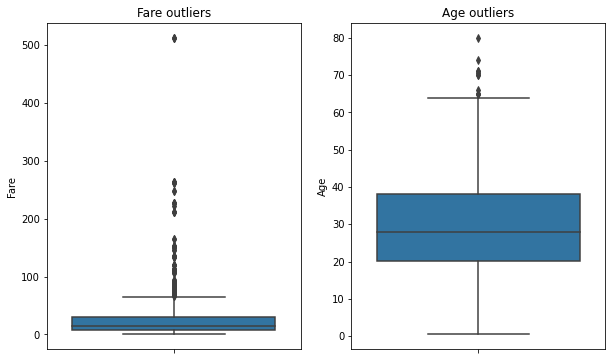

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize = (10, 6))
cols = ['Fare', 'Age'] 

for i, col in enumerate(cols):
    sns.boxplot(y = train[col], ax = ax[i]).set_title(f'{col} outliers')

The best thing to do is:
- reduce the fare more than 200 by 40 - 60 %
- reduce some age outliers by 7 - 10 years

### SibSp and Parch
Сount values of Parch.

In [3]:
train['Parch'].value_counts().sort_index()

0    678
1    118
2     80
3      5
4      4
5      5
6      1
Name: Parch, dtype: int64

Сount values of SibSp.

In [4]:
train['SibSp'].value_counts().sort_index()

0    608
1    209
2     28
3     16
4     18
5      5
8      7
Name: SibSp, dtype: int64

The best thing to do is:
- reduce Parch values from 6 - 5 to 4 - 3
- reduce SibSp values from 8 - 5 to 5 - 4

### Handling outliers
Defining functions.

In [5]:
def fare_outlier(row):
    if row['Fare'] > 400:
        return row['Fare'] * 0.4
    elif row['Fare'] > 200:
        return row['Fare'] * 0.6
    else:
        return row['Fare']

def age_outlier(row):
    if row['Age'] < 65:
        return row['Age']
    elif row['Age'] < 70:
        return row['Age'] - 7
    elif row ['Age'] < 75:
        return row['Age'] - 9
    else:
        return row['Age'] - 10

def parch_outlier(row):
    if row['Parch'] == 6:
        return 4
    elif row['Parch'] == 5:
        return 3
    else:
        return row['Parch']
    
def sibsp_outlier(row):
    if row['SibSp'] == 8:
        return 5
    elif row['SibSp'] == 5:
        return 4
    else:
        return row['SibSp']

Changing values.

In [6]:
df['Fare'] = df.apply(fare_outlier, axis = 1)
df['Age'] = df.apply(age_outlier, axis = 1)
df['Parch'] = df.apply(parch_outlier, axis = 1)
df['SibSp'] = df.apply(sibsp_outlier, axis = 1)

df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22,1,0,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",female,26,0,0,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,53.1000,S
4,0,3,"Allen, Mr. William Henry",male,35,0,0,8.0500,S


## Creating data frames
### Full
Creating a data frame without standardization and copying it for mutual information.

In [7]:
from sklearn.preprocessing import OneHotEncoder

full = df.copy()
y = full.pop('Survived')

full['Family'] = full['SibSp'] + full['Parch']
full['Name_length'] = full.apply(lambda x: len(x.Name), axis = 1)

object_cols = ['Pclass', 'Sex', 'Embarked']

OH_encoder = OneHotEncoder(handle_unknown = 'ignore', sparse = False)

OH_cols = pd.DataFrame(OH_encoder.fit_transform(full[object_cols])).astype('int64')
num_cols = full.drop(columns = ['Pclass', 'Name', 'Sex', 'Embarked'], axis = 1)

full = pd.concat([num_cols, OH_cols], axis = 1)
full = full.rename({0: 'Pclass_1', 1: 'Pclass_2', 2: 'Pclass_3', 3: 'Female', 4: 'Male', 5: 'C', 6: 'Q', 7: 'S'}, axis = 1)

m_info = full.copy()

Adding standardization.

In [8]:
from sklearn.preprocessing import StandardScaler

columns = ['Age', 'SibSp', 'Parch', 'Fare', 'Family', 'Name_length']
std_cols = full[columns]

scaler = StandardScaler().fit(std_cols)
full[columns] = scaler.transform(std_cols)

full.head()

,Age,SibSp,Parch,Fare,Family,Name_length,Pclass_1,Pclass_2,Pclass_3,Female,Male,C,Q,S
0,-0.540672,0.537313,-0.497802,-0.637531,0.095906,-0.427451,0,0,1,0,1,0,0,1
1,0.581935,0.537313,-0.497802,1.209557,0.095906,2.590962,1,0,0,1,0,1,0,0
2,-0.260020,-0.524208,-0.497802,-0.618060,-0.598831,-0.535252,0,0,1,1,0,0,0,1
3,0.371446,0.537313,-0.497802,0.685046,0.095906,1.836359,1,0,0,1,0,0,0,1
4,0.371446,-0.524208,-0.497802,-0.614454,-0.598831,-0.319651,0,0,1,0,1,0,0,1


### Partial
Let's drop some "redundant" columns with common sense.

In [9]:
partial = full.copy()
partial = partial.drop(columns = ['Family', 'Pclass_3', 'Male', 'S'])

partial.head()

,Age,SibSp,Parch,Fare,Name_length,Pclass_1,Pclass_2,Female,C,Q
0,-0.540672,0.537313,-0.497802,-0.637531,-0.427451,0,0,0,0,0
1,0.581935,0.537313,-0.497802,1.209557,2.590962,1,0,1,1,0
2,-0.260020,-0.524208,-0.497802,-0.618060,-0.535252,0,0,1,0,0
3,0.371446,0.537313,-0.497802,0.685046,1.836359,1,0,1,0,0
4,0.371446,-0.524208,-0.497802,-0.614454,-0.319651,0,0,0,0,0


### M_info
Exploring which features are valuable.


In [10]:
from sklearn.feature_selection import mutual_info_regression

mi_scores = mutual_info_regression(m_info, y, random_state = 0)
mi_scores = pd.Series(mi_scores, name = 'MI scores', index = m_info.columns)
mi_scores = mi_scores.sort_values(ascending = False)

mi_scores

Female         0.173549
Male           0.152542
Fare           0.138449
Name_length    0.082980
Family         0.074067
Pclass_3       0.056091
Pclass_1       0.051071
Age            0.038544
C              0.019158
SibSp          0.015436
S              0.015122
Pclass_2       0.008798
Q              0.001393
Parch          0.000000
Name: MI scores, dtype: float64

Let's drop the last 5 columns (from "SibSp" to "Parch").

Now I'm copying the "full" data frame with standardization.

In [11]:
m_info = full.copy()
m_info = m_info.drop(columns = ['SibSp', 'S', 'Pclass_2', 'Q', 'Parch'])

m_info.head()

,Age,Fare,Family,Name_length,Pclass_1,Pclass_3,Female,Male,C
0,-0.540672,-0.637531,0.095906,-0.427451,0,1,0,1,0
1,0.581935,1.209557,0.095906,2.590962,1,0,1,0,1
2,-0.260020,-0.618060,-0.598831,-0.535252,0,1,1,0,0
3,0.371446,0.685046,0.095906,1.836359,1,0,1,0,0
4,0.371446,-0.614454,-0.598831,-0.319651,0,1,0,1,0


### Perm_imp
I will use a random forest model to get permutation importance scores.

In [12]:
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(full, y, train_size = 0.8, random_state = 0)

model = RandomForestClassifier(random_state = 0).fit(X_train, y_train)
perm = PermutationImportance(model, random_state = 0).fit(X_val, y_val)

eli5.show_weights(perm, feature_names = X_val.columns.to_list())

Weight,Feature
0.0570 ± 0.0449,Male
0.0324 ± 0.0130,Age
0.0302 ± 0.0114,Name_length
0.0291 ± 0.0130,Fare
0.0246 ± 0.0328,Female
0.0246 ± 0.0195,Pclass_3
0.0156 ± 0.0217,Family
0.0112 ± 0.0158,SibSp
0.0101 ± 0.0130,Pclass_1
0.0034 ± 0.0114,Parch


As we can see the result is similar to the mutual information.

Let's drop the last 5 columns (from "Parch" to "S").

In [13]:
perm_imp = full.copy()
perm_imp = perm_imp.drop(columns = ['Parch', 'Q', 'Pclass_2', 'C', 'S'])

perm_imp.head()

,Age,SibSp,Fare,Family,Name_length,Pclass_1,Pclass_3,Female,Male
0,-0.540672,0.537313,-0.637531,0.095906,-0.427451,0,1,0,1
1,0.581935,0.537313,1.209557,0.095906,2.590962,1,0,1,0
2,-0.260020,-0.524208,-0.618060,-0.598831,-0.535252,0,1,1,0
3,0.371446,0.537313,0.685046,0.095906,1.836359,1,0,1,0
4,0.371446,-0.524208,-0.614454,-0.598831,-0.319651,0,1,0,1


## Hyperparameter optimization
### Setting everything we need to train models and save results

Enumeration of parameter values.

In [14]:
# Random Forest Classifier
max_depth = [12, 13, 14]
min_samples_split_rf = [3, 4, 5]

# Gradient Boosting Classifier
learning_rate = [0.15, 0.2, 0.25]
subsample = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
min_samples_split_gb = [4, 5, 6, 9]

# Logistic Regression
# Warning: some penalties may not work with some solvers
penalty = ['l1', 'l2']
C = [0.5, 0.75, 1.0, 1.25, 1.5]
solver = ['liblinear', 'saga', 'lbfgs']

# KNN
n_neighbors = [2, 3, 4, 5, 6]
p = [1, 2]

Data frames that will contain the best parameters and scores.

In [15]:
general = pd.DataFrame(columns = ['Model', 'Data', 'Score'], index = range(16))

rf = pd.DataFrame(columns = ['Data', 'Score', 'Max_depth', 'Min_samples_split'], index = range(4))
gb = pd.DataFrame(columns = ['Data', 'Score', 'Learning_rate', 'Subsample', 'Min_samples_split'], index = range(4))
lr = pd.DataFrame(columns = ['Data', 'Score', 'Penalty', 'C', 'Solver'], index = range(4))
knn = pd.DataFrame(columns = ['Data', 'Score', 'N_neighbors', 'P'], index = range(4))

rf['Data'] = ['full', 'partial', 'm_info', 'perm_imp']
gb['Data'] = ['full', 'partial', 'm_info', 'perm_imp']
lr['Data'] = ['full', 'partial', 'm_info', 'perm_imp']
knn['Data'] = ['full', 'partial', 'm_info', 'perm_imp']

### Random Forest Classifier
Define a function to train the model and get results.

In [16]:
from sklearn.model_selection import cross_val_score

def rf_get_parameters_and_scores(data):
    score = 1
    for depth in max_depth:
        for sample in min_samples_split_rf:
            model = RandomForestClassifier(max_depth = depth, min_samples_split = sample, random_state = 0)
            scores = -1 * cross_val_score(model, data, y, cv = 5, scoring = 'neg_mean_absolute_error')
            if scores.mean() < score:
                score = scores.mean()
                best_depth = depth
                best_sample = sample
    return [score, best_depth, best_sample]

Getting scores.

In [17]:
dfs = [full, partial, m_info, perm_imp]

for i, data in enumerate(dfs):
    rf.iloc[i, 1:] = rf_get_parameters_and_scores(data)

rf

,Data,Score,Max_depth,Min_samples_split
0,full,0.162733,14,5
1,partial,0.16498,13,5
2,m_info,0.163838,12,5
3,perm_imp,0.167227,12,4


### Gradient Boosting Classifier
Define a function to train the model and get results.

In [18]:
from sklearn.ensemble import GradientBoostingClassifier

def gb_get_parameters_and_scores(data):
    score = 1
    for rate in learning_rate:
        for samp in subsample:
            for sample in min_samples_split_gb:
                model = GradientBoostingClassifier(learning_rate = rate, subsample = samp, min_samples_split = sample, random_state = 0)
                scores = -1 * cross_val_score(model, data, y, cv = 5, scoring = 'neg_mean_absolute_error')
                if scores.mean() < score:
                    score = scores.mean()
                    best_rate = rate
                    best_samp = samp
                    best_sample = sample
    return [score, best_rate, best_samp, best_sample]

Getting scores.

In [19]:
for i, data in enumerate(dfs):
    gb.iloc[i, 1:] = gb_get_parameters_and_scores(data)

gb

,Data,Score,Learning_rate,Subsample,Min_samples_split
0,full,0.170561,0.15,0.5,5
1,partial,0.168332,0.15,0.6,4
2,m_info,0.172827,0.2,0.8,9
3,perm_imp,0.171697,0.25,1.0,6


### Logistic Regression
Define a function to train the model and get results.

In [20]:
from sklearn.linear_model import LogisticRegression

def lr_get_parameters_and_scores(data):
    score = 1
    for pen in penalty:
        for c in C:
            for solv in solver:
                if (solv in ['saga', 'liblinear'] and pen in ['l1', 'l2']) or (solv == 'lbfgs' and pen == 'l2'):
                    model = LogisticRegression(penalty = pen, C = c, solver = solv, max_iter = 200, random_state = 0)
                    scores = -1 * cross_val_score(model, data, y, cv = 5, scoring = 'neg_mean_absolute_error')
                    if scores.mean() < score:
                        score = scores.mean()
                        best_pen = pen
                        best_c = c
                        best_solv = solv
    return [score, best_pen, best_c, best_solv]

Getting scores.

In [21]:
for i, data in enumerate(dfs):
    lr.iloc[i, 1:] = lr_get_parameters_and_scores(data)
    
lr

,Data,Score,Penalty,C,Solver
0,full,0.205373,l2,1.0,liblinear
1,partial,0.20762,l2,1.5,saga
2,m_info,0.207602,l2,0.5,liblinear
3,perm_imp,0.209861,l1,0.75,liblinear


### KNN
Define a function to train the model and get results.

In [22]:
from sklearn.neighbors import KNeighborsClassifier

def knn_get_parameters_and_scores(data):
    score = 1
    for n in n_neighbors:
        for p_sample in p:
            model = KNeighborsClassifier(n_neighbors = n, p = p_sample)
            scores = -1 * cross_val_score(model, data, y, cv = 5, scoring = 'neg_mean_absolute_error')
            if scores.mean() < score:
                score = scores.mean()
                best_n = n
                best_p = p_sample
    return [score, best_n, best_p]

Getting scores.

In [23]:
for i, data in enumerate(dfs):
    knn.iloc[i, 1:] = knn_get_parameters_and_scores(data)
    
knn

,Data,Score,N_neighbors,P
0,full,0.181796,5,1
1,partial,0.186272,5,1
2,m_info,0.181778,3,1
3,perm_imp,0.182914,5,1


While training this model, I found out that parameters such as the leaf_size and the algorithm do not affect the accuracy of the model.

## Results overview
### Scores across all models and data frames
Filling the "general" data frame.

In [24]:
for i in range(4):
    general.iloc[i] = ['Random Forest Classifier', rf.iloc[i, 0], rf.iloc[i, 1]]
for i in range(4, 8):
    general.iloc[i] = ['Gradient Boosting Classifier', gb.iloc[i - 4, 0], gb.iloc[i - 4, 1]]
for i in range(8, 12):
    general.iloc[i] = ['Logistic Regression', lr.iloc[i - 8, 0], lr.iloc[i - 8, 1]]
for i in range(12, 16):
    general.iloc[i] = ['KNN', knn.iloc[i - 12, 0], knn.iloc[i - 12, 1]]

general['Score'] = general['Score'].astype('float64')
general.sort_values(by = 'Score')

,Model,Data,Score
0,Random Forest Classifier,full,0.162733
2,Random Forest Classifier,m_info,0.163838
1,Random Forest Classifier,partial,0.164980
3,Random Forest Classifier,perm_imp,0.167227
5,Gradient Boosting Classifier,partial,0.168332
4,Gradient Boosting Classifier,full,0.170561
7,Gradient Boosting Classifier,perm_imp,0.171697
6,Gradient Boosting Classifier,m_info,0.172827
14,KNN,m_info,0.181778
12,KNN,full,0.181796


Scores across models and data frames.

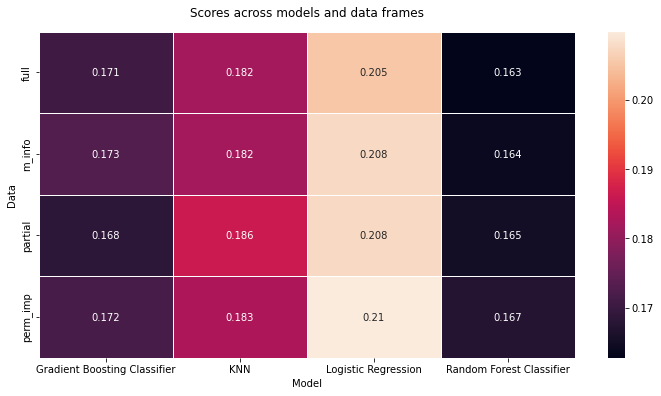

In [25]:
general_pivot = general.pivot(index = 'Data', columns = 'Model', values = 'Score')

plt.figure(figsize = (12, 6))
sns.heatmap(general_pivot, linewidths = 0.5, fmt = '.3g', annot = True).set_title('Scores across models and data frames', pad = 15)
plt.show()

### Public scores in the Titanic competition
I will test the top 10 solutions.

In [26]:
general.sort_values(by = 'Score')[:10]

,Model,Data,Score
0,Random Forest Classifier,full,0.162733
2,Random Forest Classifier,m_info,0.163838
1,Random Forest Classifier,partial,0.164980
3,Random Forest Classifier,perm_imp,0.167227
5,Gradient Boosting Classifier,partial,0.168332
4,Gradient Boosting Classifier,full,0.170561
7,Gradient Boosting Classifier,perm_imp,0.171697
6,Gradient Boosting Classifier,m_info,0.172827
14,KNN,m_info,0.181778
12,KNN,full,0.181796


Public scores:
- 0 - 0.72488
- 2 - 0.74641
- 1 - 0.74401
- 3 - 0.73444
- 5 - 0.72488
- 4 - 0.74401
- 7 - 0.71770
- 6 - 0.72248
- 14 - 0.70334
- 12 - 0.72488

### Comparison of training and test scores
Create a data frame containing the scores.

In [27]:
scores_df = general.sort_values(by = 'Score')[:10].copy()
scores_df['Train_score'] = 1 - scores_df['Score']
scores_df = scores_df.drop(columns = ['Score'])
scores_df['Test_score'] = [0.72488, 0.74641, 0.74401, 0.73444, 0.72488, 0.74401, 0.71770, 0.72248, 0.70334, 0.72488]
scores_df

,Model,Data,Train_score,Test_score
0,Random Forest Classifier,full,0.837267,0.72488
2,Random Forest Classifier,m_info,0.836162,0.74641
1,Random Forest Classifier,partial,0.835020,0.74401
3,Random Forest Classifier,perm_imp,0.832773,0.73444
5,Gradient Boosting Classifier,partial,0.831668,0.72488
4,Gradient Boosting Classifier,full,0.829439,0.74401
7,Gradient Boosting Classifier,perm_imp,0.828303,0.71770
6,Gradient Boosting Classifier,m_info,0.827173,0.72248
14,KNN,m_info,0.818222,0.70334
12,KNN,full,0.818204,0.72488


Plotting the scores.

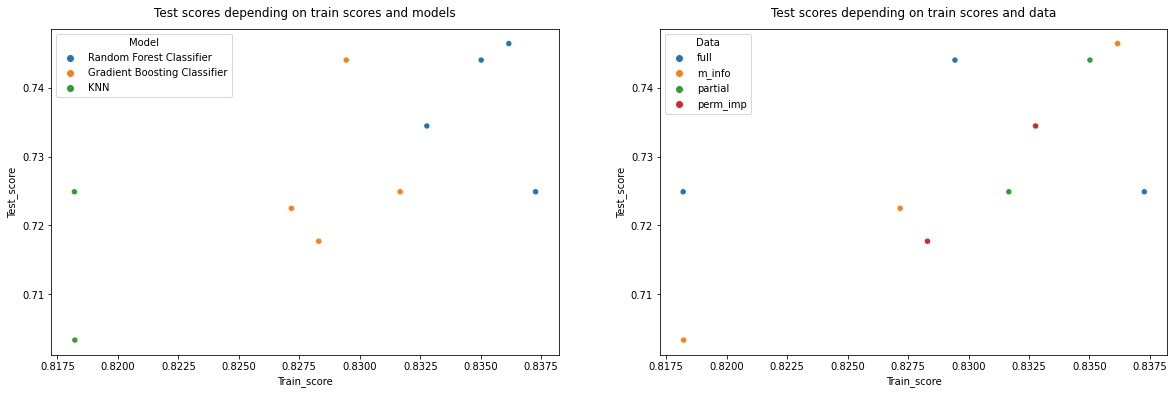

In [28]:
fig, ax = plt.subplots(1, 2, figsize = (20, 6))
sns.scatterplot(x = 'Train_score', y = 'Test_score', hue = 'Model', ax = ax[0], data = scores_df)
ax[0].set_title('Test scores depending on train scores and models', pad = 12)
sns.scatterplot(x = 'Train_score', y = 'Test_score', hue = 'Data', ax = ax[1], data = scores_df)
ax[1].set_title('Test scores depending on train scores and data', pad = 12)
plt.show()